# Установка библиотеки ultralytics

In [2]:
# разкоментировать при первом запуске
!pip install ultralytics
!pip install opencv-python

# Импорты библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image, ImageEnhance
import shutil
import torch
from ultralytics import YOLO
import random

# Загружаем датасет и фиксим в нем разметку

In [ ]:
df = pd.read_csv("/kaggle/input/sila-dataset/defects.csv", delimiter =";")

# фикс разметки и удаление строк без класса
df.rename(columns={'length': 'width', 'width': 'length'}, inplace=True)
df['y_left_bottom'] = df.apply(lambda row: row['y_left_bottom'] - row['length'], axis=1)
df = df.dropna(subset=['main_class'])

df.head()

# Добавляем название и класс без дефектов к картинкам которые не были размечены

In [ ]:
list_of_defects = list(df["filename"])
folder_path = '/kaggle/input/sila-dataset/data'
all_files = os.listdir(folder_path)
new_files = [file for file in all_files if file not in list_of_defects]


new_files_df = pd.DataFrame({'filename': new_files})


df = pd.concat([df, new_files_df], ignore_index=True)

df["main_class"].fillna('без дефектов', inplace=True)
df

# Итак здесь раскидываем по папкам и делаем аугментацию данных и кроп а так же создаем аннотации к картинкам

In [ ]:
image_folder = '/kaggle/input/sila-dataset/data'
annotations_file = df  
output_zip_path = '/kaggle/working/dataset.zip' 

In [ ]:
for split in ['train', 'val']:
    for folder in ['images', 'labels']:
        os.makedirs(os.path.join(f'/kaggle/working/{split}', folder), exist_ok=True)
    for class_name in ['царапины', 'битые пиксели', 'проблемы с клавишами', 'замок', 'отсутствует шуруп', 'сколы', 'без дефектов']:
        os.makedirs(os.path.join(f'/kaggle/working/{split}/images', class_name), exist_ok=True)
        os.makedirs(os.path.join(f'/kaggle/working/{split}/labels', class_name), exist_ok=True)

In [ ]:
def crop_and_augment(image, bbox, target_size=640):
    x_left_bottom, y_left_bottom, width, length = bbox
    
    img_width, img_height = image.size

    if any(np.isnan([x_left_bottom, y_left_bottom, width, length])):
        crop_x = (img_width - target_size) // 2
        crop_y = (img_height - target_size) // 2

        crop_x = min(max(crop_x, 0), img_width - target_size)
        crop_y = min(max(crop_y, 0), img_height - target_size)

        cropped_image = image.crop((crop_x, crop_y, crop_x + target_size, crop_y + target_size))
        return cropped_image, None 

    img_width, img_height = image.size

    crop_x = min(max(int(x_left_bottom - (target_size - width) // 2), 0), img_width - target_size)
    crop_y = min(max(int(y_left_bottom - (target_size - length) // 2), 0), img_height - target_size)

    cropped_image = image.crop((crop_x, crop_y, crop_x + target_size, crop_y + target_size))

    new_x_left_bottom = x_left_bottom - crop_x
    new_y_left_bottom = y_left_bottom - crop_y
    new_bbox = [new_x_left_bottom, new_y_left_bottom, width, length]

    return cropped_image, new_bbox

In [46]:
class_mapping = {
    'царапины': 0,
    'битые пиксели': 1,
    'проблемы с клавишами': 2,
    'замок': 3,
    'отсутствует шуруп': 4,
    'сколы': 5,
    'без дефектов': 6
}

In [ ]:
for index, row in df.iterrows():
    filename = row['filename']
    x_left_bottom = row['x_left_bottom']
    y_left_bottom = row['y_left_bottom']
    width = row['width']
    length = row['length']
    main_class = row['main_class']

    bbox = [x_left_bottom, y_left_bottom, width, length]
    image_path = os.path.join(image_folder, filename)

    
    class_folder = main_class.lower()
    split = 'train' if np.random.rand() > 0.2 else 'val'

    class_image_folder = os.path.join(f'/kaggle/working/{split}/images', class_folder)
    class_annotation_folder = os.path.join(f'/kaggle/working/{split}/labels', class_folder)
    
    saved_image_path = os.path.join(class_image_folder, filename)
    annotation_path = os.path.join(class_annotation_folder, filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.JPG', '.txt'))

    if os.path.exists(image_path):
        with Image.open(image_path) as img:
            aug_img, new_bbox = crop_and_augment(img, bbox, target_size=640)
            aug_img.save(saved_image_path)

            with open(annotation_path, 'w') as f:
                if new_bbox is None:  # сохраняем только метку класса
                    f.write(f"{class_mapping[main_class]}\n")
                else:
                    image_width, image_height = aug_img.size
                    x_center = (new_bbox[0] + new_bbox[2] / 2) / image_width
                    y_center = (new_bbox[1] + new_bbox[3] / 2) / image_height
                    norm_width = new_bbox[2] / image_width
                    norm_height = new_bbox[3] / image_height

                    f.write(f"{class_mapping[main_class]} {x_center} {y_center} {norm_width} {norm_height}\n")
    else:
        print(f"Файл не найден: {image_path}")

shutil.make_archive('/kaggle/working/dataset', 'zip', '/kaggle/working')

print(f"Архив создан и сохранен по пути: {output_zip_path}")

# Обучение ёлы

In [37]:
data_yaml_path = '/kaggle/input/sila-dataset/data.yaml' 
epochs = 50
img_size = 640
batch = 8

In [38]:
model = YOLO('/kaggle/input/sila-dataset/yolo11n.pt') 

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [40]:
results = model.train(data=data_yaml_path, epochs=epochs, imgsz=img_size, batch=batch, augment=True,  hsv_h=0.7, hsv_s=0.7, hsv_v=0.7, flipud=0.7, fliplr=0.7, mosaic=1.0, mixup=0.7)  

engine/trainer: task=detect, mode=train, model=/kaggle/input/sila-dataset/yolo11n.pt, data=/kaggle/input/sila-dataset/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, 

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /kaggle/input/sila-dataset/train/labels/битые пиксели... 67 images, 0 backgrounds, 5 corrupt: 100%|██████████| 67/67 [00:00<00:00, 276.67it/s]

train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/проблемы с клавишами/2024-01-15 17-57-27.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6516]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2023-12-26 15-38-08.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.1953]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2024-01-15 14-47-34.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.0766]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2024-01-15 16-27-01.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7062]
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/царапины/2024-01-15 18-27-22.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.4766]
train: WARNING ⚠️ Cache directory /kaggle/input/sila-dataset/train/labels is not writeab


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/sila-dataset/val/labels/битые пиксели... 20 images, 0 backgrounds, 1 corrupt: 100%|██████████| 20/20 [00:00<00:00, 270.71it/s]

val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/царапины/2024-01-15 18-28-48.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2078]
val: WARNING ⚠️ Cache directory /kaggle/input/sila-dataset/val/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.56G      3.112      5.346      2.883         12        640: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


                   all         19         19   0.000267       0.25    0.00169   0.000294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.48G      3.184      5.016      3.015         17        640: 100%|██████████| 8/8 [00:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


                   all         19         19   0.000789      0.265    0.00311   0.000614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.48G      2.876      4.981      2.638         18        640: 100%|██████████| 8/8 [00:01<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


                   all         19         19    0.00275       0.25     0.0186    0.00774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.48G      2.718      4.646       2.59         24        640: 100%|██████████| 8/8 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]

                   all         19         19    0.00353      0.182      0.166     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.48G      2.747      4.657      2.526         23        640: 100%|██████████| 8/8 [00:01<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.33it/s]


                   all         19         19    0.00321      0.167      0.166     0.0349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.48G      2.607      4.728      2.479         15        640: 100%|██████████| 8/8 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]

                   all         19         19    0.00165      0.167      0.166     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.48G      2.687       4.72      2.464         17        640: 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all         19         19   0.000838      0.167      0.166     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.48G      2.563      4.455      2.365         22        640: 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         19         19   0.000408      0.167      0.166     0.0684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.48G      2.409      4.451      2.295         15        640: 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         19         19      0.686      0.167     0.0829     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.48G       2.36      4.212      2.314         19        640: 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]


                   all         19         19     0.0002      0.167      0.166     0.0504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.48G      2.465      4.443      2.444         15        640: 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]

                   all         19         19      0.512      0.167      0.171     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.48G      2.392      4.267      2.338         15        640: 100%|██████████| 8/8 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]


                   all         19         19     0.0247      0.182      0.174     0.0928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.48G      2.542      4.299      2.407         19        640: 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.49it/s]


                   all         19         19      0.957      0.167      0.172     0.0761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.48G      2.434      4.285      2.316         17        640: 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.36it/s]


                   all         19         19      0.823      0.167      0.195      0.077

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.48G      2.431      4.215       2.35         11        640: 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.05it/s]


                   all         19         19      0.827      0.167      0.182     0.0902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.48G       2.45      3.997      2.366         12        640: 100%|██████████| 8/8 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.01it/s]


                   all         19         19      0.828      0.167      0.187      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.48G      2.372      4.033      2.279         11        640: 100%|██████████| 8/8 [00:01<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


                   all         19         19      0.893      0.182      0.186      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.48G      2.181      3.928      2.175         20        640: 100%|██████████| 8/8 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.84it/s]


                   all         19         19      0.955      0.182      0.188      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.48G      2.362      4.043      2.276         25        640: 100%|██████████| 8/8 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         19         19      0.978      0.182      0.193      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.48G      2.411      4.088      2.371         14        640: 100%|██████████| 8/8 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]

                   all         19         19      0.985      0.182      0.213      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.48G      2.311      3.855      2.261         16        640: 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.26it/s]

                   all         19         19      0.964      0.182      0.224      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.48G       2.32      3.816       2.27         17        640: 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]

                   all         19         19      0.987      0.194      0.225      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.48G       2.32      3.916      2.245         11        640: 100%|██████████| 8/8 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         19         19      0.882      0.197      0.219      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.48G       2.14      3.656       2.13         13        640: 100%|██████████| 8/8 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         19         19      0.995      0.167        0.2      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.48G      2.248      3.718      2.277         22        640: 100%|██████████| 8/8 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]

                   all         19         19      0.886      0.182      0.209      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.48G      2.165      3.757      2.164         17        640: 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

                   all         19         19      0.961      0.182      0.223      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.48G      2.282      3.784      2.281         25        640: 100%|██████████| 8/8 [00:01<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


                   all         19         19      0.896      0.182       0.22      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.48G      2.244      3.703      2.174         16        640: 100%|██████████| 8/8 [00:01<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]

                   all         19         19      0.843      0.182      0.227      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.48G      2.211      3.731      2.186         21        640: 100%|██████████| 8/8 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]

                   all         19         19      0.846      0.182      0.224       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.48G       2.19       3.56      2.147         19        640: 100%|██████████| 8/8 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         19         19      0.893       0.18      0.218      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.48G      2.267      3.623      2.195         22        640: 100%|██████████| 8/8 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


                   all         19         19      0.826      0.242      0.239     0.0965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.48G       2.19      3.627      2.253         10        640: 100%|██████████| 8/8 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         19         19      0.837      0.252      0.243     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.48G      2.226      3.719      2.174         24        640: 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


                   all         19         19      0.931      0.224      0.257      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.48G      2.107      3.466      2.089         15        640: 100%|██████████| 8/8 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         19         19      0.892      0.257      0.256       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.48G       2.11      3.605      2.122         11        640: 100%|██████████| 8/8 [00:01<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]

                   all         19         19      0.883      0.258      0.261      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.48G      2.255      3.614      2.146         20        640: 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]


                   all         19         19      0.895      0.242        0.3      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.48G      2.125      3.427      2.102         17        640: 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]

                   all         19         19      0.946      0.212      0.298      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.48G       2.14      3.501      2.174         20        640: 100%|██████████| 8/8 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         19         19       0.89      0.215      0.297      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.48G       2.19      3.601      2.242         19        640: 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


                   all         19         19      0.694      0.212      0.294      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.48G       2.27      3.589      2.213         14        640: 100%|██████████| 8/8 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         19         19      0.916      0.184      0.287      0.146


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.48G      2.055      4.193      2.218          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


                   all         19         19      0.932      0.182      0.287       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.48G      1.994       4.39      2.103          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


                   all         19         19      0.896      0.212      0.283      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.48G      2.092      4.424        2.3          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


                   all         19         19      0.872      0.242      0.289      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.48G      2.051      4.393      2.222          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         19         19      0.501      0.261      0.294      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.48G      2.097      4.207      2.178          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


                   all         19         19      0.502      0.258      0.293      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.48G      2.061      4.262      2.194          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


                   all         19         19      0.696      0.258      0.298      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.48G      2.051      4.333       2.15          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


                   all         19         19      0.727      0.227      0.297       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.48G      2.071      4.345      2.221          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         19         19      0.753      0.227      0.302       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.48G      2.095      4.354      2.147          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.88it/s]


                   all         19         19      0.762      0.227      0.304      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.48G      2.055      4.166      2.285          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]

                   all         19         19      0.759      0.227      0.303      0.187



50 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 5.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.11 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


                   all         19         19      0.862      0.273      0.312      0.193
              царапины          1          1          1          0          0          0
         битые пиксели         11         11      0.517      0.636       0.54      0.258
  проблемы с клавишами          2          2          1          0          0          0
                 замок          1          1      0.653          1      0.995      0.697
     отсутствует шуруп          1          1          1          0          0          0
                 сколы          3          3          1          0      0.336      0.201
Speed: 0.2ms preprocess, 9.7ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train5


lr/pg0,▁▂▃▄▄▅▆▆▇▇███▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▁▂▃▄▄▆▇▇█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▁▂▃▄▄▅▇▇█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▁▁▁▅▅▅▅▃▅▅▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▆▇▇▇██▇▇▇▇█████
metrics/mAP50-95(B),▁▁▁▂▃▃▂▃▄▄▄▄▅▅▅▅▅▅▆▆▇▆▅▅▅▅▆▇▇█▇▆▆▇▇▇▇███
metrics/precision(B),▁▁▁▁▁▁▁▆▁▅█▇▇▇████▇██▇▇▇▇▇█▇▇▇▇▆▇█▇▅▅▆▆▆
metrics/recall(B),▆▇▆▂▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▁▂▂▂▂▂▇▅▇▇▆▄▄▂▂▄▇▇▇▅█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▆▅▅▅▄▃▃▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▃▂▂▁▁▂▂▁▁▁▁


# Отображение предсказаний модели


image 1/1 /kaggle/input/sila-dataset/train/images/битые пиксели/20240115_C223013936.jpg: 640x640 1 битые пиксели, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
0.7493540644645691


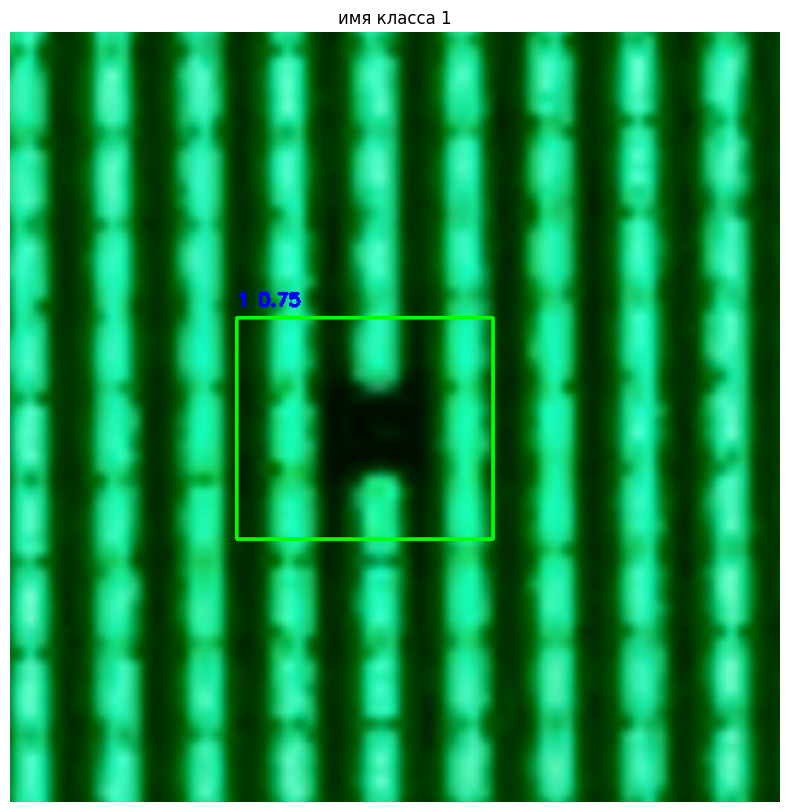

In [57]:
import cv2

model_load = YOLO('/kaggle/working/runs/detect/train5/weights/best.pt')

test_image_path = '/kaggle/input/sila-dataset/train/images/битые пиксели/20240115_C223013936.jpg'  # вставляем картинку которую хотим проверить
image = cv2.imread(test_image_path)


results = model_load(test_image_path, conf=0.05)

for result in results[0].boxes:  
    x1, y1, x2, y2 = result.xyxy[0].tolist()  
    confidence = result.conf[0].item()
    print(confidence)
    class_id = int(result.cls[0].item())      

    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # добавляем метку класса
    class_label = class_id
    cv2.putText(image, f"{class_label} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

output_path = '/kaggle/working/prediction_with_boxes.jpg'
cv2.imwrite(output_path, image)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"имя класса {class_label}")
plt.show()
# мин эвередж присижен метрика популярна она берет среднюю точность по всем классам
# локальная модель у нас а не апи не нужны внешние сервисы самая маленькая 

# Ответ на вопрос для любопытных почему пришлось фиксить разметку - в изначальном датасете были перепутаны местами ширина и высота, а так же координата x левого нижнего угла а координата y левого верхнего если возьмете изначальный датасет и попробуете запустить код ниже то увидите что квадратик появляется не там где надо) но фикс весьма простой если понимать как работает геометрия
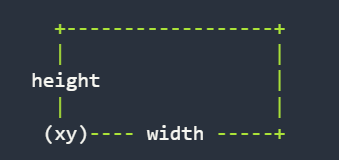

In [ ]:
def display_image_with_bbox(row, image_dir):
    img_path = os.path.join(image_dir, row['filename'])
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    
    x_lb = int(row['x_left_bottom'])
    y_lb = int(row['y_left_bottom'])
    length = int(row['length'])
    width_box =  int(row['width'])
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    
    rect = plt.Rectangle((x_lb, y_lb), width_box, length, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.title(f"картинка {row['filename']}")
    plt.axis('off')
    plt.show()
    

In [ ]:
display_image_with_bbox(df.iloc[80], image_folder)